In [33]:
import torch 
import math
import cv2
import numpy as np 
import torch.optim as optim
import matplotlib.pyplot as plt
import timeit 
import torch.nn.functional as F
from tqdm import tqdm
import time
from models import PGGAN, utils, config
from torch import multiprocessing
from degradationOperator import degradeBatch
from style_transfer import transfer
from finetuning import parallelTrain

In [34]:
#!pip install sporco
#!pip install segyio
from sporco import array,plot,util
import segyio

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load poststack image**

In [36]:
segyfile = 'datasets/real_stack.segy'

f = segyio.open(segyfile, ignore_geometry=True)

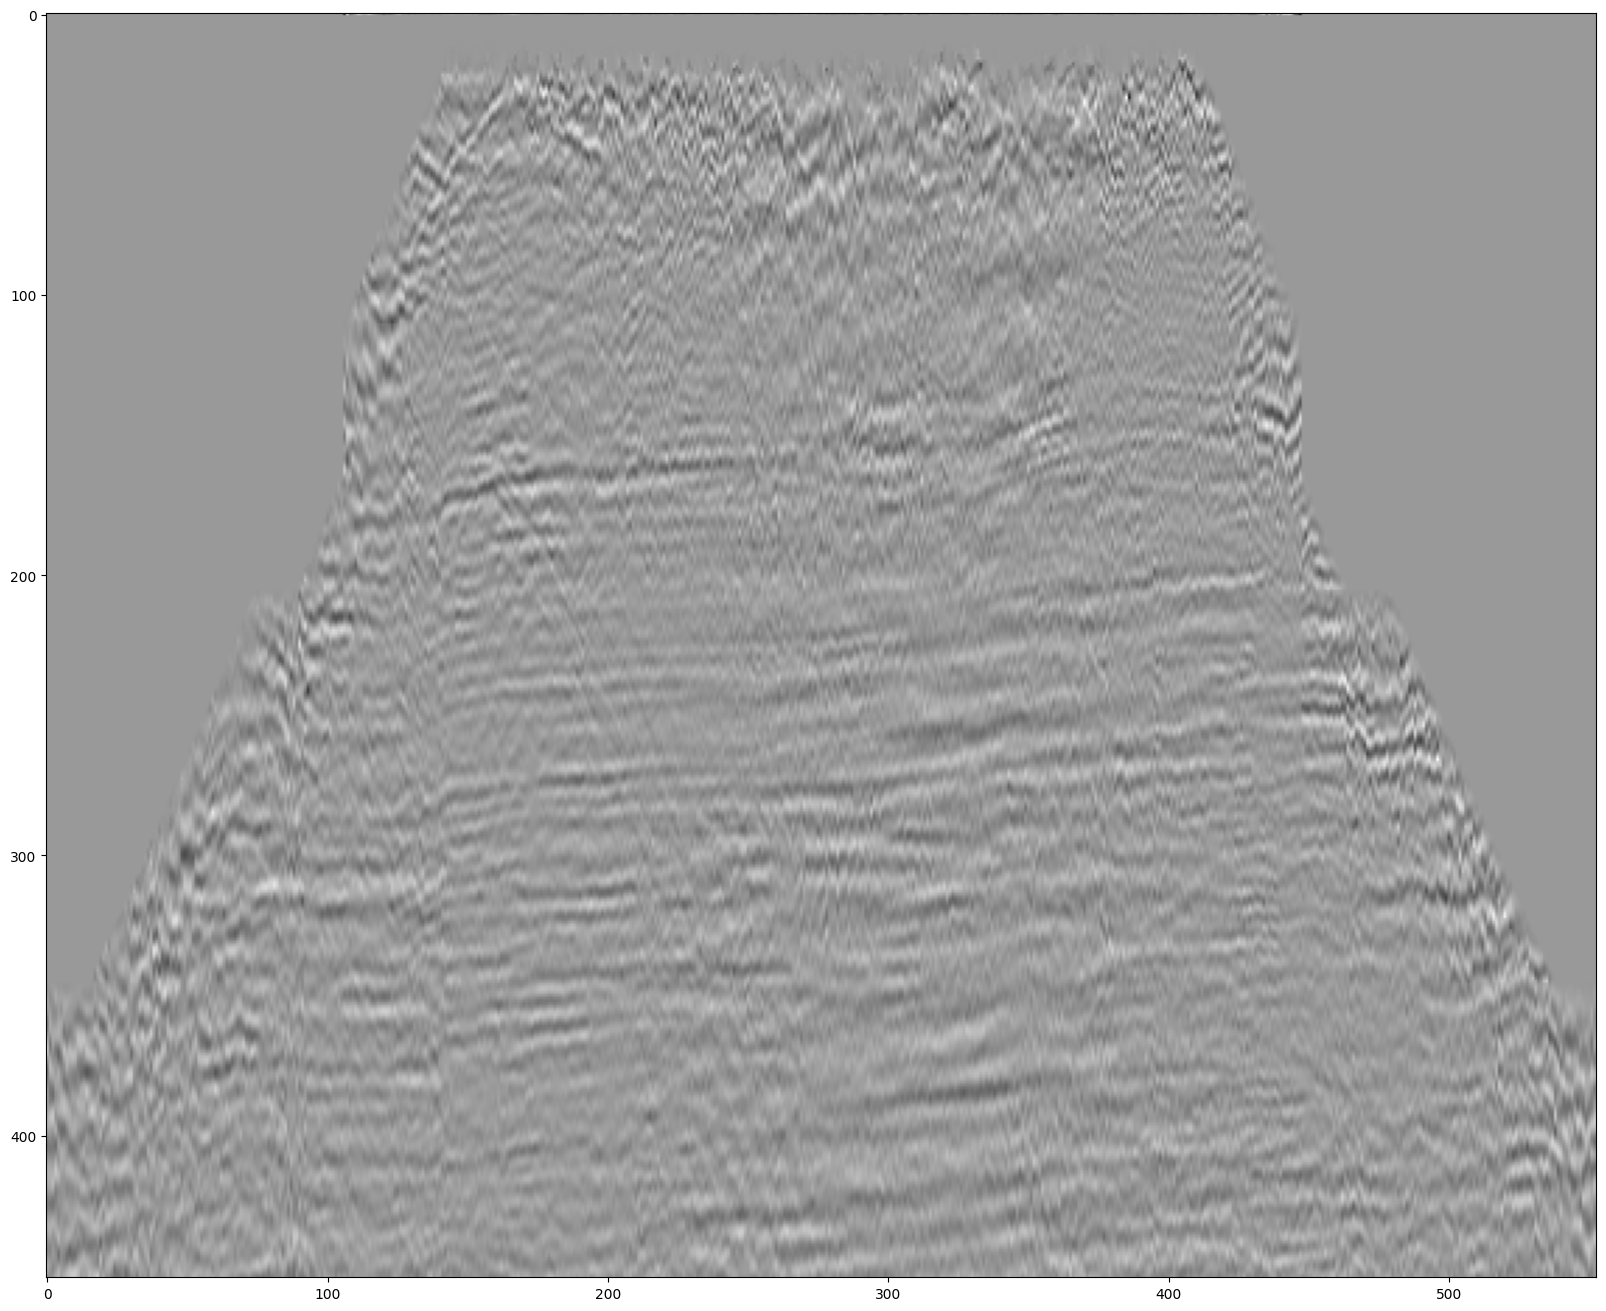

In [37]:
figsize=(20, 20)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
axs = axs.ravel()
im = axs[0].imshow(f.trace.raw[:].T, cmap="gray")


In [38]:
def mirror_padding(image, top_padding, bottom_padding, left_padding, right_padding):
    h, w = image.shape
    new_h = h + top_padding + bottom_padding
    new_w = w + left_padding + right_padding
    padded_image = np.zeros((new_h, new_w), dtype=image.dtype)
    
    padded_image[top_padding:top_padding + h, left_padding:left_padding + w] = image
    
    if top_padding > 0:
        padded_image[:top_padding, left_padding:left_padding + w] = image[:top_padding][::-1]
    
    if bottom_padding > 0:
        padded_image[top_padding + h:, left_padding:left_padding + w] = image[-bottom_padding:][::-1]
    
    if left_padding > 0:
        padded_image[top_padding:top_padding + h, :left_padding] = image[:, :left_padding][:, ::-1]
    
    if right_padding > 0:
        padded_image[top_padding:top_padding + h, left_padding + w:] = image[:, -right_padding:][:, ::-1]
    
    if top_padding > 0 and left_padding > 0:
        padded_image[:top_padding, :left_padding] = image[:top_padding, :left_padding][::-1, ::-1]
    
    if top_padding > 0 and right_padding > 0:
        padded_image[:top_padding, left_padding + w:] = image[:top_padding, -right_padding:][::-1, ::-1]
    
    if bottom_padding > 0 and left_padding > 0:
        padded_image[top_padding + h:, :left_padding] = image[-bottom_padding:, :left_padding][::-1, ::-1]
    
    if bottom_padding > 0 and right_padding > 0:
        padded_image[top_padding + h:, left_padding + w:] = image[-bottom_padding:, -right_padding:][::-1, ::-1]
    
    return padded_image
def padding(img):
    padd_img = img
    if (img.shape[0] % 128 != 0):
        pad = math.ceil(img.shape[0]/128)*128 - img.shape[0]
        if pad%2==0:
            top = pad/2
            bot = pad/2
        else:
            top = math.ceil(pad/2)
            bot = math.floor(pad/2)
        padd_img = mirror_padding(img,top,bot,0,0)
    if (img.shape[1] % 128 != 0):
        pad = math.ceil(img.shape[1]/128)*128 - img.shape[1]
        if pad%2==0:
            lf = pad/2
            rt = pad/2
        else:
            lf = math.ceil(pad/2)
            rt = math.floor(pad/2)
        padd_img = mirror_padding(padd_img,0,0,lf,rt)
    return padd_img, top, bot, lf, rt

**Padded image if necessary**

(451, 553)


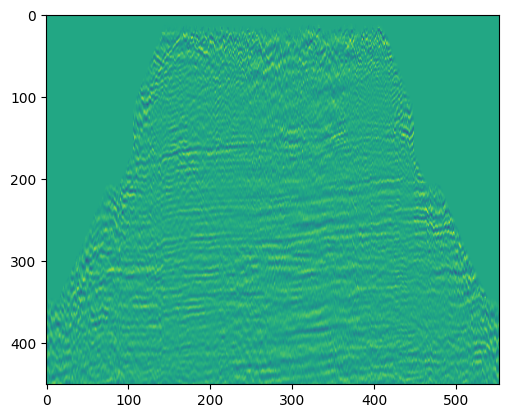

In [39]:
original = f.trace.raw[:].T
original = original[:original.shape[0],:original.shape[1]]
original = (original - np.min(original))/(np.max(original) - np.min(original))
# plt.imshow(TestData, cmap='seismic' ),plt.clim([0,1])
TestData, top, bot, lf, rt = padding(original)
print(original.shape)
plt.imshow(original)
plt.show()

In [40]:
singleffid = TestData.copy()
blksz = (128,128)
stpsz = (32,32)
blcks_corrupt = array.extract_blocks(singleffid, blksz, stpsz)
blcks_non_corrupt = array.extract_blocks(TestData, blksz, stpsz)

In [41]:
subblcks_corrupt = blcks_corrupt.transpose(2,0,1)
subblcks_non_corrupt = blcks_non_corrupt.transpose(2,0,1)
subblcks_non_corrupt = torch.from_numpy(subblcks_non_corrupt).unsqueeze(1)
subblcks_corrupt = torch.from_numpy(subblcks_corrupt).unsqueeze(1)

**Import model and load weigths**

In [42]:
from models.Attention_unet import AttU_Net

In [43]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('checkpoints/att_u_fine.pt'))

<All keys matched successfully>

In [44]:
subblcks_corrupt.shape

torch.Size([221, 1, 128, 128])

**EXP 3 : RECONSTRUCTION POSTSTACK IMAGE**

In [45]:
data_loader = torch.utils.data.DataLoader(subblcks_corrupt, batch_size=40)

In [46]:
denoised_tensor_list = []
for batch in tqdm(data_loader):
    with torch.no_grad():
        denoised_batch = model(batch.to(device))
        denoised_tensor_list.append(denoised_batch.cpu())
recov_blcks = torch.cat(denoised_tensor_list, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.20it/s]


In [47]:
recov_blcks = recov_blcks.numpy().transpose(0,2,3,1)
subblcks_corrupt = subblcks_corrupt.numpy().transpose(0,2,3,1)
subblcks_non_corrupt = subblcks_non_corrupt.numpy().transpose(0,2,3,1)

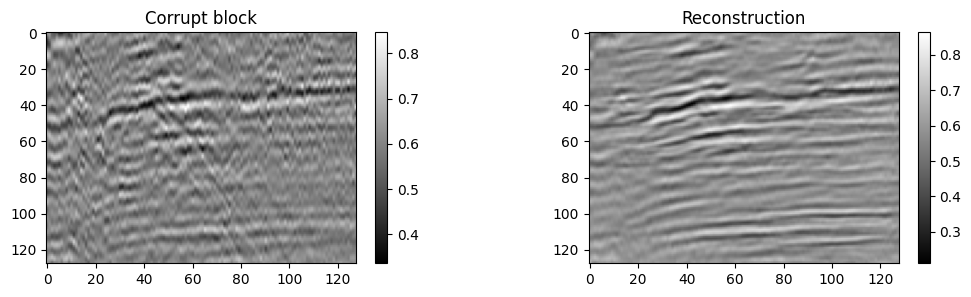

In [48]:
kk =90
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(subblcks_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), #plt.clim([0.5,0.64])
plt.colorbar()

plt.title("Corrupt block")

plt.subplot(122)
plt.imshow(recov_blcks[kk,:,:,0],aspect='auto',cmap='gray'), 
plt.colorbar()
plt.title("Reconstruction")


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [49]:
del denoised_tensor_list

In [50]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [51]:
start = timeit.default_timer()
#imgd_median = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)
print("creating image from patching, time is:",
              timeit.default_timer() - start)
imgd_median.shape

creating image from patching, time is: 7.396770800000013


(512, 640)

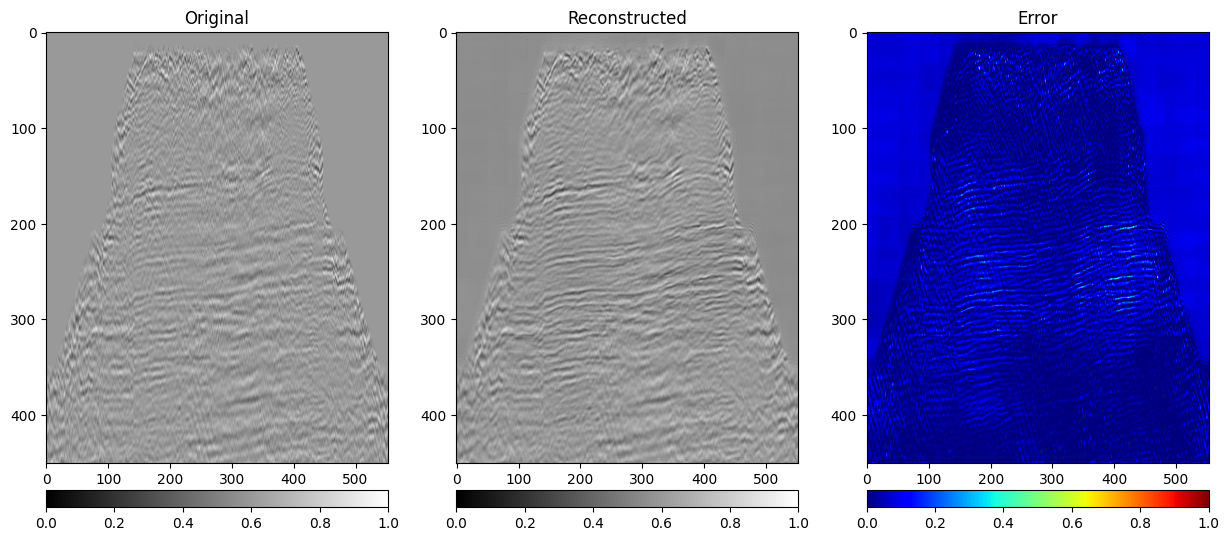

In [52]:
plt.figure(figsize=(15,7))

err = original-imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt]
err /= np.max(np.abs(err))

plt.subplot(131)
plt.imshow(original,aspect='auto',cmap='gray')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt],aspect='auto',cmap='gray'), plt.clim([0,1])
plt.title('Reconstructed')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(133)
plt.imshow(err,aspect='auto',cmap='jet'),
plt.clim([0,1])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

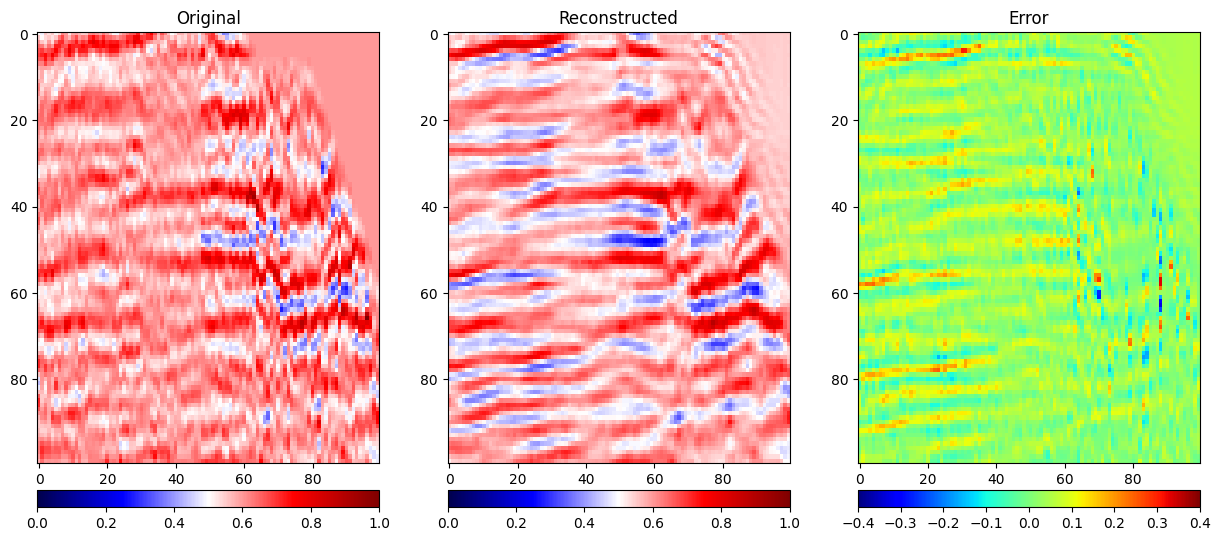

In [53]:
err_section = original[200:300,400:500]-imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][200:300,400:500]

plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(original[200:300,400:500],aspect='auto',cmap='seismic')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][200:300,400:500],aspect='auto',cmap='seismic'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(err_section,aspect='auto',cmap='jet'),
plt.clim([-.4,.4])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

**Fine-tuning: Domain adaptation with style transfer**

Section to adapt

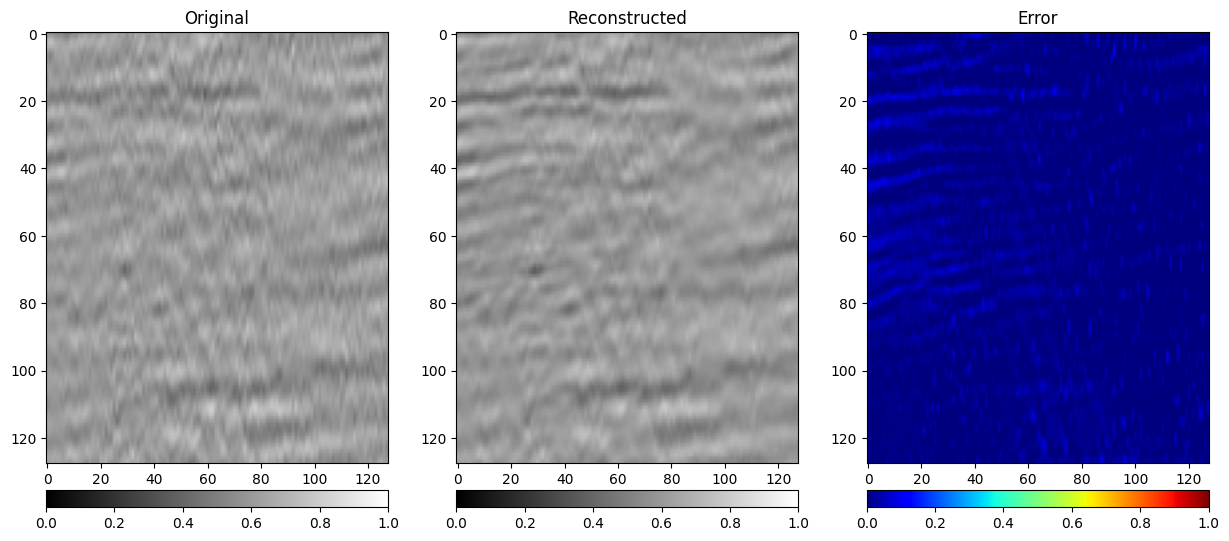

In [54]:
plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(original[323:,186:314],aspect='auto',cmap='gray')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][323:,186:314],aspect='auto',cmap='gray'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(original[323:,186:314]-imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][323:,186:314],aspect='auto',cmap='jet'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Error')
plt.show()

Run fine-tuning

In [23]:
section = original[186:314,425:]
batch_size=5
epochs=30 
iterations=2 
gen_samples=10
parallelTrain(section, batch_size, epochs, iterations, gen_samples)

torch.Size([10, 1, 128, 128]) torch.Size([1, 1, 128, 128])


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\juter\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\juter\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juter\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

mean time image degradation:  19.020847821235655
loading time images:  190.7906014919281
damages: torch.Size([10, 5, 128, 128])
0
1


In [24]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('att_u_fine.pt'))

<All keys matched successfully>

In [25]:
denoised_tensor_list = []
for batch in tqdm(data_loader):
    with torch.no_grad():
        denoised_batch = model(batch.to(device))
        denoised_tensor_list.append(denoised_batch.cpu())
recov_blcks = torch.cat(denoised_tensor_list, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.31it/s]


In [26]:
recov_blcks = recov_blcks.numpy().transpose(0,2,3,1)
#subblcks_corrupt = subblcks_corrupt.numpy().transpose(0,2,3,1)
#subblcks_non_corrupt = subblcks_non_corrupt.numpy().transpose(0,2,3,1)

In [27]:
del denoised_tensor_list

In [28]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [29]:
start = timeit.default_timer()
#imgd_median = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)
print("creating image from patching, time is:",
              timeit.default_timer() - start)
imgd_median.shape

creating image from patching, time is: 7.559648100000004


(512, 640)

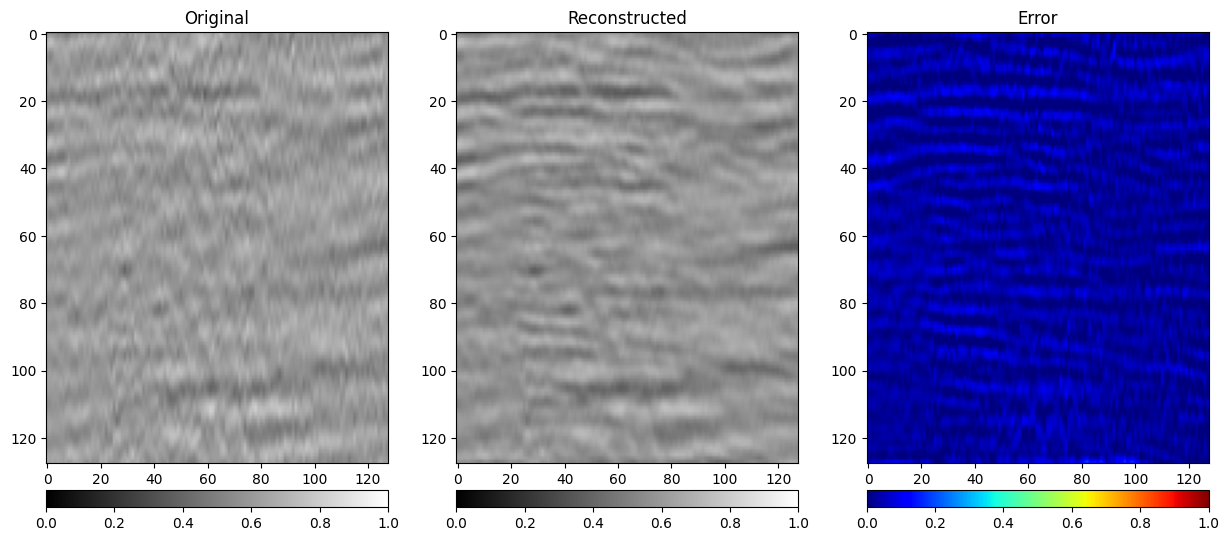

In [30]:
plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(original[323:,186:314],aspect='auto',cmap='gray')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][323:,186:314],aspect='auto',cmap='gray'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(original[323:,186:314]-imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][323:,186:314],aspect='auto',cmap='jet'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Error')
plt.show()